In [1]:
# This is so that matplotlib plots directly in the notebook.
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cvxopt
from sklearn.preprocessing import normalize

In [4]:
networks = {"karate" : "data/karate/karate.gml",
         "polbooks" : "data/polbooks/polbooks.gml",
         "football" : "data/football/football.gml",
         "dolphins" : "data/dolphins/dolphins.gml",
         "neural" : "data/celegansneural/celegansneural.gml",
           "netscience" : "data/netscience/netscience.gml"}

<h1> Loading and Drawing Networks </h1>

We will use NetworkX to load networks stored as .gml files. For now, we start with the simple Karate network, where nodes correspond to members of a karate club, and edges indicate friendship outside of the club. There are 34 nodes in this network.

In [5]:
G = nx.read_gml(networks["karate"])
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.diameter(G))

34
78
5


For modularity clustering, the main thing needed is the adjacency matrix of this network.

In [6]:
# Note: This gives an error with NetworkX 1.10, although
#       there are no problems with 1.9.1
W = nx.adjacency_matrix(G).astype(float)

The <code>draw_networkx</code> function will draw networks for us. One difficulty in visually representing networks is the matter of node placement. Here we use the <code>spring_layout</code> heuristic for positioning nodes: roughly speaking, edges are replaced with "springs" and the resulting minimum energy configuration is determines node positions.

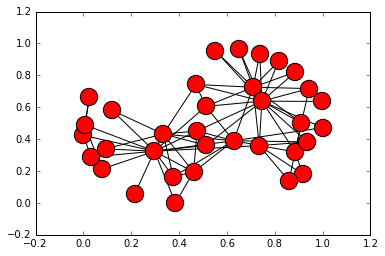

In [7]:
nx.draw_networkx(G, ax=plt.subplot(111),pos = nx.spring_layout(G), with_labels=False)

<h1> The Modularity Matrix </h1>

Given a weight matrix $W$, the modularity matrix $Q$ is defined by
$$ Q_{ij} = \frac{1}{2s}\Big(W_{ij} - \frac{d_i d_j}{2s}\Big) $$
where $d_i$ is the degree of vertex $i$, and $s = \frac{1}{2}\sum_{ij} W_{ij}$.

In [8]:
def modmatrix(W):
    assert sp.sparse.isspmatrix(W), "Expected a sparse matrix."
    m,n = W.shape
     
    e = np.ones(m)
    # The degree of vertex i is \sum_j W_{ij}, 
    # so the degree vector is simply W*e
    d = W*e
    
    # s is the total weight of all edges
    s = (0.5)*np.dot(e,d)

    P = np.outer(d,d.T) / (2*s)
    Q = (W - P) / (2*s) # This is stored as a *dense* matrix.
    
    return Q

In [9]:
Q = modmatrix(W)

<h1> Solving the Semidefinite Relaxation </h1>

<b>TODO: cite thesis </b>

The semidefinite program we wish to solve is 
$$
\begin{equation*}
\begin{aligned}
 \hspace{0.5cm} & \underset{Z}{\text{maximize}}
& & \mbox{trace}(QZ) \\
& \text{subject to}
& &  Z_{ii} = 1, \, \, i = 1,\ldots,n, \\
& & & Z \succeq 0.
\end{aligned}
\end{equation*}
$$

This problem is the Lagrange dual of
$$
\begin{equation*}
\begin{aligned}
 \hspace{0.5cm} & \underset{x}{\text{minimize}}
& & 1^T x \\
& \text{subject to}
& &  \mbox{diag}(x) - W \succeq 0.
\end{aligned}
\end{equation*}
$$


The CVXOPT package has a convenient interface for solving semidefinite programs. The <a href="http://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.sdp"><code>cvxopt.solvers.sdp</code></a> function takes a specification of a primal-dual pair and executes the solver. To make use of this, we must shoehorn our problem into the required format. Below is a wrapper around the CVXOPT procedure. We take the dual (i.e. maximization) problem as our starting point.

In [9]:
def modsdp(Q):
    # The G matrix encodes the diagonal constraint on Z.
    def makeG(n):
        I = []
        J = []
        for i in range(0,n):
            I += [i]
            J += [n*i + i]
        return cvxopt.spmatrix(1.0, I, J, size=(n,n*n)).T

    m,n = Q.shape
    # Our constraint: Z_{ii} + c_i = 0
    c = cvxopt.matrix(-np.ones(n))
    # Sign convention.
    h = -cvxopt.matrix(Q)
    G = makeG(n)
    # Use the default solver for the primal-dual problem.
    sol = cvxopt.solvers.sdp(c, Gs=[G], hs = [h])
    # We only want the dual solution Z.
    return np.array(sol['zs'][0])    


In [10]:
Z = modsdp(Q)
Z.shape

     pcost       dcost       gap    pres   dres   k/t
 0: -4.9803e-02 -4.9803e-02  4e+01  6e+00  0e+00  1e+00
 1: -4.1014e-02 -4.1013e-02  2e+00  3e-01  2e-15  4e-02
 2:  2.7664e-01  2.7703e-01  9e-01  2e-01  1e-15  3e-02
 3:  4.4333e-01  4.4354e-01  4e-01  6e-02  1e-15  1e-02
 4:  5.6804e-01  5.6825e-01  3e-01  5e-02  2e-15  8e-03
 5:  7.0746e-01  7.0750e-01  6e-02  1e-02  1e-15  2e-03
 6:  7.4176e-01  7.4177e-01  1e-02  2e-03  8e-16  4e-04
 7:  7.5054e-01  7.5054e-01  3e-03  5e-04  1e-15  9e-05
 8:  7.5277e-01  7.5277e-01  2e-04  4e-05  7e-16  6e-06
 9:  7.5292e-01  7.5292e-01  4e-05  7e-06  7e-16  1e-06
10:  7.5294e-01  7.5294e-01  1e-05  2e-06  5e-16  4e-07
11:  7.5295e-01  7.5295e-01  3e-06  5e-07  9e-16  8e-08
12:  7.5295e-01  7.5295e-01  4e-07  7e-08  8e-16  1e-08
Optimal solution found.


(34, 34)

<h1> Rounding the Solution </h1>

The resulting solution $Z$ solves the <i>relaxed</i> modularity maximization problem (the semidefinite program above). A procedure for converting this into a feasible solution for the original, NP-hard modularity maximization problem is called a <i>rounding</i> method. Here we implement a few approaches.

<h2> Goemans-Williamson Rounding </h2>



In [11]:
def goemans(Q,Z,l=1000):
    """ Apply the Goemans-Williamson rounding procedure.
        Q is the modularity matrix, Z is the relaxed solution.
        The rounding is randomized, iterate l times and return the best result. """
    m,n = Z.shape

    V = np.linalg.cholesky(Z)
    # goemans calls for rho to be a unit vector, but that isn't necessary
    rhos = np.random.multivariate_normal(np.zeros(m), np.identity(m),l) 
    zs = np.sign(np.dot(V,rhos.T)) # columns represent cluster membership
    mods = np.diag(np.dot(np.dot(zs.T,Q),zs))
    i = np.argmax(mods)
    c = ((zs[:,i]+1)/2).astype(int)
    return c

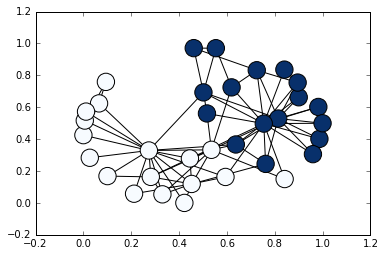

In [12]:
c1 = goemans(Q,Z)
ax = plt.subplot(111)
nx.draw_networkx(G, ax=ax,pos = nx.spring_layout(G), with_labels=False, node_color=c1, cmap=plt.cm.Blues)

<h2> Generalized Goemans-Williamson </h2>

In [82]:
def goemansK(Q,X,k=10,l=1000):
    m,n = X.shape

    V = np.linalg.cholesky(X).T
    
    
    projS = make_projS(k)
        

    maxq = 0.0
    for i in range(0,l):
        Q1,_ = sp.linalg.qr(np.random.randn(m,k), mode='economic')
        V1 = np.dot(Q1.T, V)
        
        c = projS(V1.T)
        # modularity
        q = mod_labels(Q,c)
        if (q > maxq):
            maxq = q
            maxc = c
    return maxc

def make_projS(k):
    E = np.identity(k)
    S = normalize(E - 1./k,axis=0)
    def projS(V):
        # project rows of V onto columns of V
        D = np.dot(V,S)
        return np.argmax(D, axis=1)
    return projS

def mod_labels(Q,c):
    # input should be a n-vector of integer labels in the range [0,n)
    m,n = Q.shape
    E = np.identity(n)
    C = E[c]
    M = np.inner(C,C)
    return np.sum(np.multiply(Q,M))

In [ ]:
def friezeK(Q,X,k=10,l=1000):
    m,n = X.shape

    V = np.linalg.cholesky(X).T
    
    S = normalize(np.random(n,k),axis=0)

In [83]:
c2 = goemansK(Q,Z,k=10,l=1000)

In [84]:
def compare_clusterings(G,Q,c1,c2):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches(16, 8)

    pos = nx.spring_layout(G)
    for ax,c in [(ax1,c1),(ax2,c2)]:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        nx.draw_networkx(G, ax=ax,pos=pos, with_labels=False, node_color=c, cmap=plt.cm.Blues)
        ax.set_title("mod = %f" % mod_labels(Q,c))


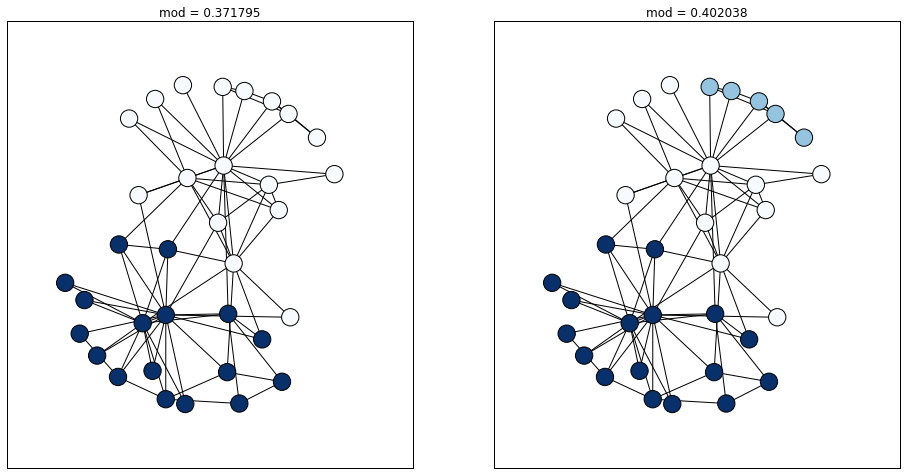

In [85]:
compare_clusterings(G,Q,c1,c2)

<h2> Generalized Bertsimas-Ye Rounding </h2>

In [17]:
def bertyeK(Q,X,k=10,l=20):
    m,n = X.shape
    L = np.linalg.cholesky(X)
    
    E = np.identity(k)
    S = normalize(E - 1./k)
    projS = make_projS(k)

    maxq = 0.0
    for i in range(0,l):
        # rows of V are iid ~ N(0, identity(k))
        V = np.random.multivariate_normal(np.zeros(k), np.identity(k), n)
        V = np.dot(L,V)
        # project rows of V onto S
        c = projS(V)
        q = mod_labels(Q,c)
        if q > maxq:
            maxq = q
            maxc = c

    return maxc

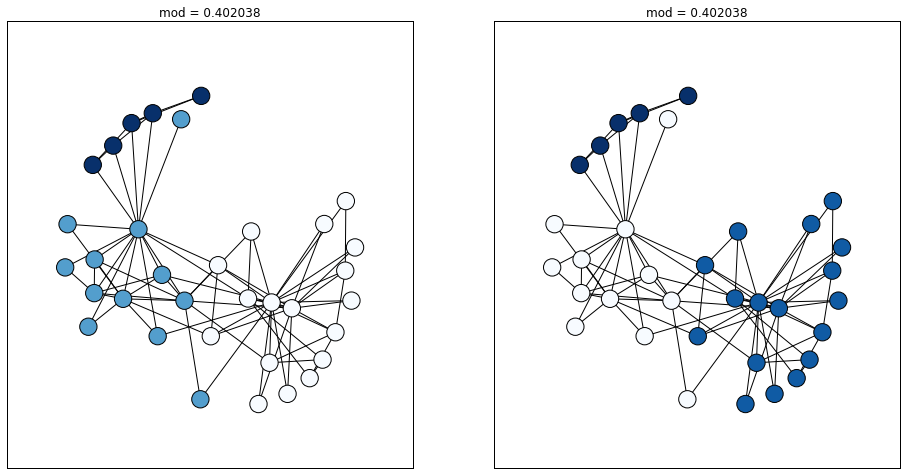

In [18]:
compare_clusterings(G,Q,c2,bertyeK(Q,Z,l=5000))

<h1> An Optimized Solver </h1>

In [268]:
# Fast SDP solver, from http://cvxopt.org/userguide/coneprog.html#exploiting-structure
# The code below takes advantage of the special structure of the KKT system associated
# with our semidefinite program.

def fastsdp(Q):
    """
    Returns solution x, z to

        (primal)  minimize    sum(x)
                  subject to  w + diag(x) >= 0

        (dual)    maximize    -tr(w*z)
                  subject to  diag(z) = 1
                              z >= 0.
    """

    w = -cvxopt.matrix(Q)
    n = w.size[0]
    c = cvxopt.matrix(1.0, (n,1))

    def G(x, y, alpha = 1.0, beta = 0.0, trans = 'N'):
        """
            y := alpha*(-diag(x)) + beta*y.
        """

        if trans=='N':
            # x is a vector; y is a symmetric matrix in column major order.
            y *= beta
            y[::n+1] -= alpha * x

        else:
            # x is a symmetric matrix in column major order; y is a vector.
            y *= beta
            y -= alpha * x[::n+1]


    def cngrnc(r, x, alpha = 1.0):
        """
        Congruence transformation

            x := alpha * r'*x*r.

        r and x are square matrices.
        """

        # Scale diagonal of x by 1/2.
        x[::n+1] *= 0.5

        # a := tril(x)*r
        a = +r
        tx = cvxopt.matrix(x, (n,n))
        cvxopt.blas.trmm(tx, a, side = 'L')

        # x := alpha*(a*r' + r*a')
        cvxopt.blas.syr2k(r, a, tx, trans = 'T', alpha = alpha)
        x[:] = tx[:]

    dims = {'l': 0, 'q': [], 's': [n]}

    def F(W):
        """
        Returns a function f(x, y, z) that solves

                      -diag(z)     = bx
            -diag(x) - r*r'*z*r*r' = bz

        where r = W['r'][0] = W['rti'][0]^{-T}.
        """

        rti = W['rti'][0]

        # t = rti*rti' as a nonsymmetric matrix.
        t = cvxopt.matrix(0.0, (n,n))
        cvxopt.blas.gemm(rti, rti, t, transB = 'T')

        # Cholesky factorization of tsq = t.*t.
        tsq = t**2
        cvxopt.lapack.potrf(tsq)

        def f(x, y, z):
            """
            On entry, x contains bx, y is empty, and z contains bz stored
            in column major order.
            On exit, they contain the solution, with z scaled
            (vec(r'*z*r) is returned instead of z).

            We first solve

               ((rti*rti') .* (rti*rti')) * x = bx - diag(t*bz*t)

            and take z = - rti' * (diag(x) + bz) * rti.
            """

            # tbst := t * bz * t
            tbst = +z
            cngrnc(t, tbst)

            # x := x - diag(tbst) = bx - diag(rti*rti' * bz * rti*rti')
            x -= tbst[::n+1]

            # x := (t.*t)^{-1} * x = (t.*t)^{-1} * (bx - diag(t*bz*t))
            cvxopt.lapack.potrs(tsq, x)

            # z := z + diag(x) = bz + diag(x)
            z[::n+1] += x

            # z := -vec(rti' * z * rti)
            #    = -vec(rti' * (diag(x) + bz) * rti
            cngrnc(rti, z, alpha = -1.0)

        return f

    sol = cvxopt.solvers.conelp(c, G, w[:], dims, kktsolver = F)
    return np.array(sol['z']).reshape(n,n)

In [282]:
cvxopt.solvers.options["show_progress"] = False
%timeit modsdp(Q)

10 loops, best of 3: 82.7 ms per loop


In [283]:
%timeit fastsdp(Q)

10 loops, best of 3: 39.9 ms per loop


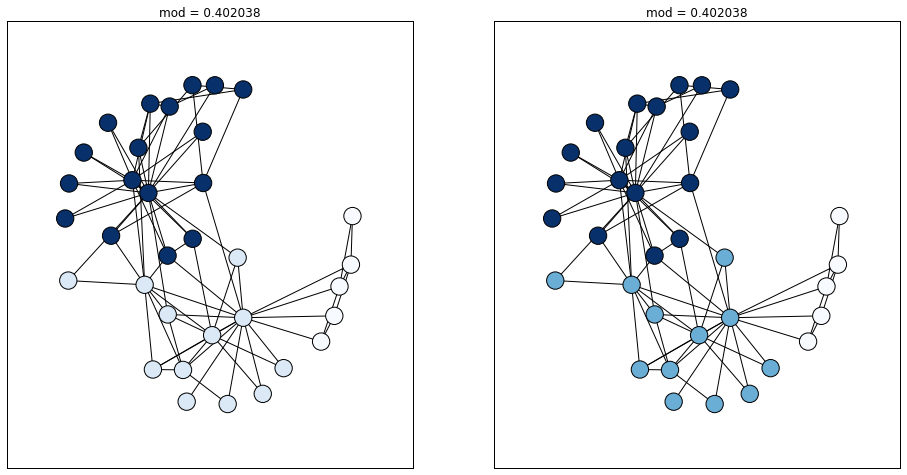

In [284]:
Z = fastsdp(Q)
compare_clusterings(G,Q,goemansK(Q,Z,l=5000),bertyeK(Q,Z,l=5000))

In [118]:
def experiment(l=5000):

    for f in networks:
        G = nx.read_gml(networks[f])
        W = nx.adjacency_matrix(G).astype(float)
        Q = modmatrix(W)
        #Z = fastsdp(Q)
        Z = rbr(Q)
    
        c2 = goemans(Q,Z,l=l)
        cgw = goemansK(Q,Z,k=10,l=l)
        cby = bertyeK(Q,Z,k=10,l=l)
        # cf = frieze(Q,X,k=10,l=l)
        print("%s %d (vp2 %f) (gw %f) (by %f)" % (f, len(G.nodes()), 
                                                          mod_labels(Q,c2), 
                                                          mod_labels(Q,cgw),
                                                          mod_labels(Q,cby)))


In [119]:
experiment()

1. delta = 0.287910
2. delta = 0.095741
3. delta = 0.053410
4. delta = 0.027297
5. delta = 0.009344
6. delta = 0.004372
7. delta = 0.001890
8. delta = 0.000748
neural 297 (vp2 0.283799) (gw 0.308922) (by 0.314359)
1. delta = 0.605160
2. delta = 0.094597
3. delta = 0.019198
4. delta = 0.010324
5. delta = 0.006139
6. delta = 0.003755
7. delta = 0.002354
8. delta = 0.001505
9. delta = 0.000980
football 115 (vp2 0.400356) (gw 0.492574) (by 0.503006)
1. delta = 0.623280
2. delta = 0.113876
3. delta = 0.020107
4. delta = 0.005337
5. delta = 0.001796
6. delta = 0.000765
dolphins 62 (vp2 0.402733) (gw 0.490784) (by 0.504173)
1. delta = 0.676621
2. delta = 0.147626
3. delta = 0.019684
4. delta = 0.003469
5. delta = 0.000830
polbooks 105 (vp2 0.456875) (gw 0.499596) (by 0.505242)
1. delta = 0.627666
2. delta = 0.084430
3. delta = 0.011782
4. delta = 0.003188
5. delta = 0.001092
6. delta = 0.000424
karate 34 (vp2 0.371795) (gw 0.399080) (by 0.402038)
1. delta = 0.839094
2. delta = 0.055034
3. del

KeyboardInterrupt: 

In [19]:
2 if 3 > 1 else 4

2

In [126]:
-

In [136]:
G = nx.read_gml(networks["football"])
W = nx.adjacency_matrix(G).astype(float)
Q = modmatrix(W)


1. delta = 0.368870
2. delta = 0.164279
3. delta = 0.094528
4. delta = 0.057736
5. delta = 0.023742
6. delta = 0.007283
7. delta = 0.005089
8. delta = 0.004139
9. delta = 0.004451
10. delta = 0.004150
11. delta = 0.002111
12. delta = 0.001989
13. delta = 0.001246
14. delta = 0.000743
15. delta = 0.000788
16. delta = 0.001126
17. delta = 0.000268
18. delta = 0.001175
19. delta = -0.000044
20. delta = 0.000486
21. delta = 0.000341
22. delta = 0.000281
23. delta = 0.000191
24. delta = 0.000452
25. delta = 0.000091
26. delta = 0.000043
27. delta = 0.000100
28. delta = 0.000025
29. delta = -0.000163
30. delta = 0.000259
31. delta = -0.000014
32. delta = 0.000065
33. delta = 0.000043
34. delta = 0.000063
35. delta = 0.000197
36. delta = -0.000275
37. delta = -0.000281
38. delta = 0.000438
39. delta = -0.000174
40. delta = 0.000154
41. delta = 0.000163
42. delta = -0.000043
43. delta = 0.000190
44. delta = -0.000190
45. delta = 0.000262
46. delta = -0.000190
47. delta = 0.000004
48. delta = -

1. delta = 0.411431
2. delta = 0.186997
3. delta = 0.058863
4. delta = 0.034961
5. delta = 0.016826
6. delta = 0.006493
7. delta = 0.008203
8. delta = 0.004565
9. delta = 0.002955
10. delta = 0.002920
11. delta = 0.002524
12. delta = 0.001647
13. delta = 0.001405
14. delta = 0.001333
15. delta = 0.001110
16. delta = 0.000605
17. delta = 0.000403
18. delta = 0.000830
19. delta = 0.000073
20. delta = 0.000554
21. delta = -0.000236
22. delta = 0.000345
23. delta = 0.000515
24. delta = -0.000217
25. delta = 0.000679
26. delta = -0.000118
27. delta = -0.000100
28. delta = 0.000160
29. delta = -0.000114
30. delta = 0.000180


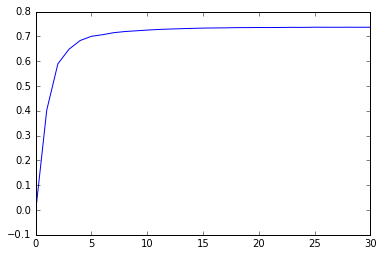

In [144]:
_,Fs = random_rbr(Q,iters=30)
plt.plot(-np.array(Fs))

In [78]:
c = 2*M[mask,i]

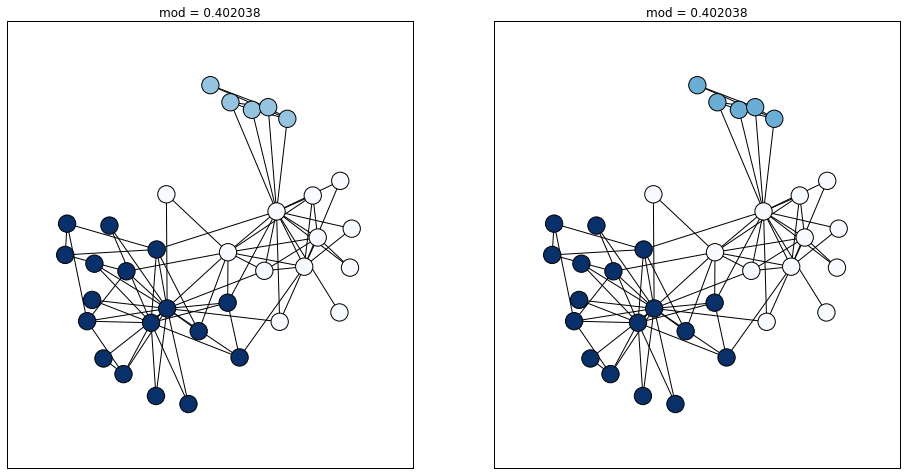

In [117]:
compare_clusterings(G,Q,c2,bertyeK(Q,C,k=3,l=5000))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)